In [77]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tools import merge_matrix, hic_norm, clean_matrix

In [139]:
cell_line, chr = 'IMR90', 10
chr_file_name = 'chr{}_1000b.npz'.format(chr)
analyse_path = '/data1/lmh_data/MMSR_complete/analyse/'
hr_path = os.path.join(analyse_path, cell_line, 'use_data', 'hr', chr_file_name)
result_path = os.path.join(analyse_path, cell_line, 'validation', chr_file_name)

hr = np.load(hr_path)['hic']
print(hr.shape)
print(hr.max())

result = np.load(result_path)['out']
print(result.shape)
print(result.max())

hr[hr!=0] = 1
result[result!=0] = 1
hr = hr.astype(np.uint8)
result = result.astype(np.uint8)

hr = merge_matrix(hr)
hr = np.triu(hr).T + np.triu(hr)

result = merge_matrix(result)
result = np.triu(result).T + np.triu(result)

(335, 5, 400, 400)
19828.0
(335, 5, 400, 400)
204.60423278808594


In [140]:
chrom = 'chr{}'.format(chr)
significants = []

import csv
from enum import Enum


class Position(Enum):
    enhancer_chrom = 1
    enhancer_end = 3
    enhancer_start = 5
    label = 6
    promoter_chrom = 7
    promoter_end = 8
    promoter_start = 10


with open(os.path.join(analyse_path, 'EPI_DLMH', 'data', '{}.csv'.format(cell_line)), 'r') as f:
    reader = csv.reader(f)
#     print(type(reader))
    headers = next(reader)
#     print(headers)
    
    for row in reader:
        if row[Position.label.value] == "0":
            continue
        if row[Position.enhancer_chrom.value] != row[Position.promoter_chrom.value]:
            continue
        if row[Position.enhancer_chrom.value] != chrom:
            continue

        enhancer_start = int(int(row[Position.enhancer_start.value]) / 1000)
        enhancer_end = int(int(row[Position.enhancer_end.value]) / 1000)
        promoter_start = int(int(row[Position.promoter_start.value]) / 1000)
        promoter_end = int(int(row[Position.promoter_end.value]) / 1000)

        for enhancer_position in range(enhancer_start, enhancer_end + 1):
            for promoter_position in range(promoter_start, promoter_end + 1):
                significants.append((enhancer_position, promoter_position))

print(len(significants))

147


In [141]:
hr_significant, result_significant = [], []
for significant in significants:
    if significant[0] >= hr.shape[0] or significant[1] >= hr.shape[1]:
        print(str(significant[0]) + " " + str(significant[1]))
        continue
    y, x = significant[0], significant[1]
    radius = 1
    y_min, x_min = max(y - radius, 0), max(x - radius, 0)
    y_max, x_max = min(y + radius, hr.shape[0]), max(x + radius, hr.shape[1])
    if hr[y_min:y_max, x_min:x_max].mean() > 0:
        hr_significant.append((y, x))
    if result[y_min:y_max, x_min:x_max].mean() > 0:
        result_significant.append((y, x))

print(len(hr_significant))
print(len(result_significant))

save_path = os.path.join(analyse_path, cell_line, 'significant', 'chr{}_1000b'.format(chr))
np.savez_compressed(save_path, all=np.array(significants), hr=np.array(hr_significant), result=np.array(result_significant))

134441 134351
134441 134351
134441 134351
134441 134351
134442 134351
134444 134351
134445 134351
134446 134351
134446 134351
134447 134351
137
128


In [142]:
print('{}/{}'.format(len(hr_significant), np.count_nonzero(hr)))
print('{}/{}'.format(len(result_significant), np.count_nonzero(result)))

137/12681147
128/5693677


In [143]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        pass
 
    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass
 
    return False

gene_location_file_path = os.path.join(analyse_path, 'gene_location', 'mart_export.txt')

class Position(Enum):
    gene_stable_ID = 0
    gene_stable_ID_version = 1
    chromosome = 2
    gene_start = 3
    gene_end = 4

gene_location = np.zeros(result.shape[0])
with open(gene_location_file_path, 'r') as f:
    reader = csv.reader(f)
    headers = next(reader)
    print(headers)

    for row in reader:
        if not is_number(row[Position.chromosome.value]):
            continue
        _chr = int(row[Position.chromosome.value])
        if _chr != chr:
            continue
        _start = int(int(row[Position.gene_start.value])/1000)
        _end = int(int(row[Position.gene_end.value])/1000)
        for i in range(_start, _end+1):
            gene_location[i] = 1

print(gene_location.sum())
print(len(gene_location))

['Gene stable ID', 'Gene stable ID version', 'Chromosome/scaffold name', 'Gene start (bp)', 'Gene end (bp)']
80453.0
134000


In [144]:
attention = 10

def find_length(gene_location, promoter_location):
    length = 0
    while True:
        if length >= attention:
            return -1
        if gene_location[promoter_location+length] or gene_location[promoter_location-length]:
            return length
        length += 1

hr_nums = np.zeros(attention)
for significant in hr_significant:
    promoter = significant[1]
    num = find_length(gene_location, promoter)
    if num >= 0:
        hr_nums[num] += 1
print(hr_nums)

result_nums = np.zeros(attention)
for significant in result_significant:
    promoter = significant[1]
    num = find_length(gene_location, promoter)
    if num >= 0:
        result_nums[num] += 1
print(result_nums)

[96.  0.  0.  0.  0.  2. 18.  0.  0.  0.]
[90.  0.  0.  0.  0.  2. 18.  0.  0.  0.]


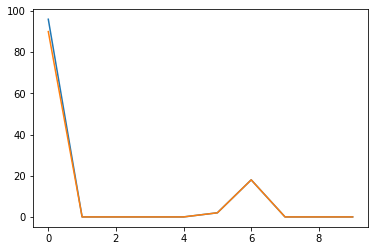

[96.  0.  0.  0.  0.  2. 18.  0.  0.  0.]
[90.  0.  0.  0.  0.  2. 18.  0.  0.  0.]


In [145]:
x = range(attention)

hr_y, result_y = hr_nums/len(hr_significant), result_nums/len(result_significant)
plt.plot(x, hr_nums)
plt.plot(x, result_nums)
plt.show()

print(hr_nums)
print(result_nums)